# Scalable Random search and Bayesian Optimization with Random Forests 

This notebook investigas Random Search and Bayesian Optimization to optimize Random Forest. 
The data used is a highly inbalanced credit card transaction data set with around 250000 rows. 
This research aims to investigate possibilities to use python-based optimization methods (based on Scikit, Dask) for an easy approach on optimization for Big Data sets.

Investigated are:
1. Random search in Scikit-Learn
2. Random search in Dask
3. Bayesian optimization in Scikit-Learn

Random search is a fast, simple way of optimization. Bayesian optimization is "smarter", as in it uses previous iterations to decide what values to test next. It can be a bit slower than Random Search, but will most likely need less iterations to find the best combination of hyperparameters.

These methods are tested and compared on efficiency. The research is focused on scalability, so the main focus is whether the optimization methods are able to be used on Big Data. The run-time is therefore important, but also the number of iterations needed to converge. 

In [229]:
import pandas as pd
from sklearn.model_selection import ParameterSampler
import numpy as np
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import dask_ml.model_selection as dcv
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
import seaborn as sns
from statistics import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from time import time
from operator import itemgetter
from sklearn.datasets import load_digits
from scipy.stats import expon
from sklearn import svm, datasets
from imblearn.combine import SMOTETomek # doctest: +NORMALIZE_WHITESPACE
from hyperopt import hp
from sklearn.ensemble import RandomForestClassifier
from hyperopt import STATUS_OK
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import tpe
from timeit import default_timer as timer
import skopt
from skopt import BayesSearchCV

## Data and preprocessing

A large Kaggle dataset with credit card transactions is used. It is a clean dataset: no null values. 
We do not need to normalize the data, as we are using Random Forests which do not require normalized data. 
The main challenge is the fact that this data is highly inbalanced: only a very small percentage of the data is a fraud.

For data preparation, we will import a test and train set. The test set will not be used until the very end, after the optimization part for a final testing run. The train set (80% of the data) will be used for training and validation (using CV).

To fix the data imbalance issue, we use SMOTE (oversampling) and Tomek links (undersampling). 

In [21]:
df = pd.read_csv('train.csv').head(20000) #training set (train + val)
test = pd.read_csv('test.csv')

In [22]:
#check for null values
print("Null values in train set:", df.isnull().sum().sum())
print("Null values in train set:", test.isnull().sum().sum())

Null values in train set: 0
Null values in train set: 0


In [23]:
train_features = df.drop(columns=['Class'])
train_labels = df.Class

In [24]:
test_features = test.drop(columns=['Class'])
test_labels = test.Class

In [25]:
#check class imbalance
frauds = len([train_labels == 1])
print("Only" ,frauds/len(train_labels), "percent of the transactions in this set are fraudulent.")

Only 5e-05 percent of the transactions in this set are fraudulent.


In [26]:
#balance before
balance = Counter(train_labels)
print(balance)

#SMOTETomek
resample = SMOTETomek()
train_features, train_labels = resample.fit_resample(train_features, train_labels)

Counter({0: 19915, 1: 85})


In [27]:
#balance after
counter = Counter(train_labels)
print(counter)

Counter({0: 19890, 1: 19890})


## Search space

The search space will be the same for all optimization methods, to make a fair comparison. 

In [28]:
#Define the parameter grid

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

space = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [ ]:
#Globals
N_ITER = 50
CV = 3

## Scoring

In [506]:
def get_preds(method, X, y, printing=False):
    preds = method.predict(X)
    if printing == True:
        return(get_scores(y, preds, method, printing=True))
    return get_scores(y, preds, method)

In [127]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [507]:
def get_scores(y, preds, method, printing=False):
    accuracy = accuracy_score(y, preds)
    rocauc = roc_auc_score(y, preds)
    print("Results of", method)
    print("accuracy:", accuracy)
    print("rocauc:", rocauc)
    if printing == True:
        return(preds)

## Random Search in Skicit

In [132]:
model = RandomForestClassifier(n_jobs = -1)

In [133]:
random_search_scikit = RandomizedSearchCV(estimator=model, param_distributions = space, n_iter = N_ITER, cv = CV,
                                         random_state = 42, return_train_score = True, scoring="roc_auc")
start = time()

random_search_scikit.fit(train_features, train_labels)

print("RandomizedSearchCV with Scikit took %.2f seconds for %d" 
      " iterations." % ((time() - start), N_ITER))

RandomizedSearchCV with Scikit took 7917.42 seconds for 50 iterations.


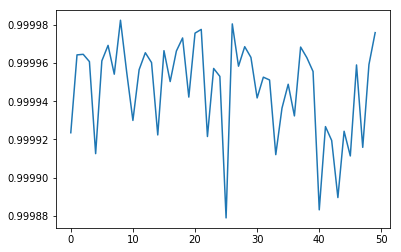

In [134]:
random_search_scikit.cv_results_
plt.plot(random_search_scikit.cv_results_['mean_test_score'])

In [274]:
pd.DataFrame(random_search_scikit.cv_results_).to_csv('results_rs_scikit.csv')

## Random Search in Dask

In [135]:
random_search_dask = dcv.RandomizedSearchCV(model, space, n_iter=N_ITER, cv=CV, random_state = 42, return_train_score = True, 
                                            scoring="roc_auc")
start = time()

random_search_dask.fit(train_features, train_labels)

print("RandomizedSearchCV with Dask took %.2f seconds for %d" 
      " iterations." % ((time() - start), N_ITER))

RandomizedSearchCV with Dask took 6724.07 seconds for 50 iterations.


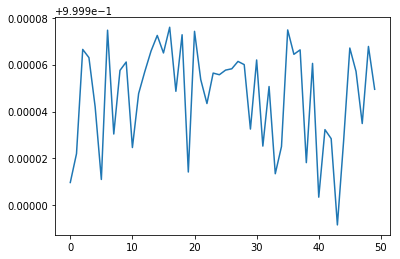

In [136]:
random_search_dask.cv_results_
plt.plot(random_search_dask.cv_results_['mean_test_score'])

In [275]:
pd.DataFrame(random_search_dask.cv_results_).to_csv('results_rs_dask.csv')

## Bayesian Optimization in Scikit



In [ ]:
bayesian_opt_skopt = BayesSearchCV(model, space, n_iter=N_ITER, cv=CV, random_state = 42, return_train_score = True, 
                                  scoring = "roc_auc")
start = time()

bayesian_opt_skopt.fit(train_features, train_labels)

In [280]:
print("BayesSearchCV with Skopt took %.2f seconds for %d"
     " iterations." % ((time() - start), N_ITER))

BayesSearchCV with Skopt took 6018.28 seconds for 50 iterations.


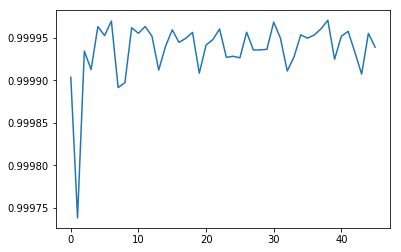

In [281]:
bayesian_opt_skopt.cv_results_
plt.plot(bayesian_opt_skopt.cv_results_['mean_test_score'])

In [282]:
pd.DataFrame(bayesian_opt_skopt.cv_results_).to_csv('results_bo_skopt.csv')

## Evaluation

### Number of iterations vs CV score

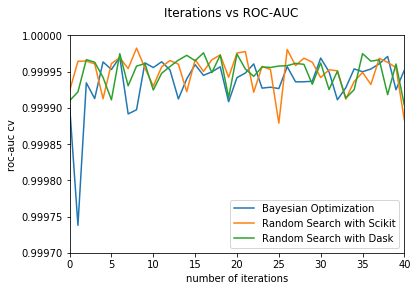

In [290]:
axes = plt.gca()
axes.set_xlim([0,40])
axes.set_ylim([0.9997,1])
plt.xlabel("number of iterations")
plt.ylabel("roc-auc cv")
rss = random_search_scikit.cv_results_['mean_test_score']
rsd = random_search_dask.cv_results_['mean_test_score']
bss = bayesian_opt_skopt.cv_results_['mean_test_score']
plt.plot(bss, label='Bayesian Optimization')
plt.plot(rss, label='Random Search with Scikit')
plt.plot(rsd, label='Random Search with Dask')
plt.suptitle('Iterations vs ROC-AUC')
plt.legend()
plt.show()

### Runtime

In [284]:
#runtimes in seconds
time_scikit = 7917.42
time_dask = 6724.07
time_bayes = 6018.28

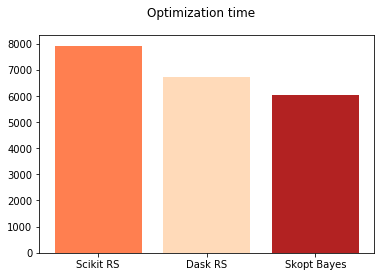

In [285]:
height = [time_scikit, time_dask, time_bayes]
bars = ('Scikit RS', 'Dask RS', 'Skopt Bayes')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, color=("coral", "peachpuff", "firebrick"))
plt.xticks(y_pos, bars)
plt.suptitle('Optimization time')
plt.show()

### Fit optimized classifiers on the data

We will here fit the Random Forests using the found hyperparameter setting on the train data. It is then tested on the test data: this is the data that is left out completely at the beginning. It is not preprocessed (so it is very imbalanced!) and unseen. The test data provides us with two scores: accuracy and roc-auc. Since the data is very imbalanced, auc-roc is much more meaningful than accuracy.

The results show that the random search (both dask and sklearn) leaves us with a very bad roc-auc score. The accuracy is high: but, if the predictor would predict every input as non-fraudulent, the accuracy would still be around 0.99. 
Bayesian optimization gives us a much better roc-auc score. It is still not the best predictor, but it is significantly improved compared to the baseline and the random searches. 

This notebook only used 20000 inputs from the dataset. It is possible than, when using the whole set for optimizing and fitting, the results in general would be much better.

#### Baseline

In [494]:
baseline_pred = []
for i in range(56961):
    baseline_pred.append(0)
    
accuracy = accuracy_score(test_labels, baseline_pred)
rocauc = roc_auc_score(test_labels, baseline_pred)
print('Accuracy of the baseline:', accuracy)
print('ROC-AUC of the baseline:', rocauc)

Accuracy of the baseline: 0.9986833096329067
ROC-AUC of the baseline: 0.5


#### Optimized Random Forests

In [295]:
params_rs = random_search_scikit.best_params_
params_rsd = random_search_dask.best_params_
params_bo = bayesian_opt_skopt.best_params_

In [299]:
#Random Search in Scikit
random_forest_scikit = RandomForestClassifier(n_jobs=-1, **params_rs)
random_forest_dask = RandomForestClassifier(n_jobs=-1, **params_rsd)
random_forest_bayes = RandomForestClassifier(n_jobs=-1, **params_bo)

In [370]:
random_forest_scikit.fit(train_features, train_labels)
get_preds(random_forest_scikit, test_features, test_labels) 

Results of RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
accuracy: 0.9988939800916417
rocauc: 0.5866578771578245


In [391]:
random_forest_dask.fit(train_features, train_labels)
get_preds(random_forest_dask, test_features, test_labels)

Results of RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
accuracy: 0.9988764242200804
rocauc: 0.5866490876489822


In [302]:
random_forest_bayes.fit(train_features, train_labels)
get_preds(random_forest_bayes, test_features, test_labels)

Results of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
accuracy: 0.9991748740366215
rocauc: 0.7199560524557889


In [495]:
accuracy_bs = 0.9987
roc_bs = 0.5

accuracy_rfs = 0.9989
roc_rfs = 0.5867

accuracy_rfd = 0.9989
roc_rfd = 0.5866

accuracy_rfb = 0.9992
roc_rfb = 0.7200

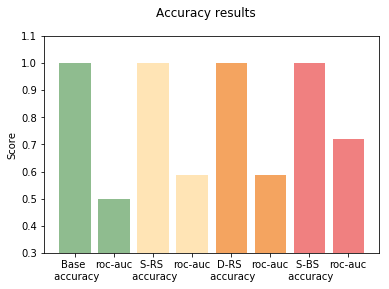

In [496]:
height = [accuracy_bs, roc_bs, accuracy_rfs, roc_rfs, accuracy_rfd, roc_rfd, accuracy_rfb, roc_rfb]
bars = ('Base \n accuracy', 'roc-auc', 'S-RS \n accuracy', 'roc-auc', 'D-RS \n accuracy',
        'roc-auc', 'S-BS \n accuracy', 'roc-auc')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, width=0.8, color=("darkseagreen", "darkseagreen", "moccasin", "moccasin", "sandybrown", "sandybrown", "lightcoral", "lightcoral"))
plt.xticks(y_pos, bars)
plt.suptitle('Accuracy results')
plt.ylabel("Score")
plt.ylim([0.3,1.1])
plt.show()